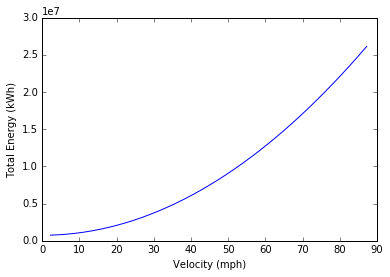

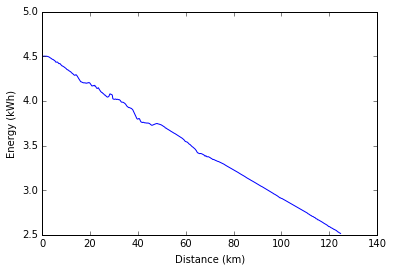

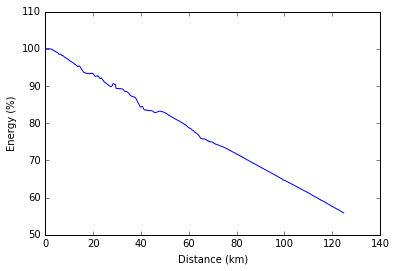

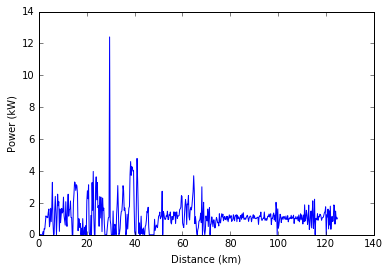

In [36]:
%matplotlib inline
from math import sin, cos, pi, atan
import csv
import matplotlib.pyplot as plt
import random
import numpy as np

# Currently using Zephyr data, stick with that for now, update to Tachyon stats later
# what amount of battery cap should be minimum?
# EDIT weather array so its the same length as the distance_readings array (not hardcoded 512)
# TODO How do we create weather array?

Cd = 0.17
A = 1.15
roll_resist_co = 0.0025
mass = 285 # Zephyr car + driver mass (kg)
g = 9.8 #kg-m/s^2
battery_percentage = 100.0 #starting battery percentage
battery_capacity = 4.5 # kwh (Zephyr - Tachyon is more like 15?)
num_stops_est = .0625 # stops per km - (1 per 16 km ~ 10miles)
array_power = {"rain":150, "cloudy":300.0, "partly_cloudy":500.0, "sun":1000.0, "bright_sun": 1250.0} # array power under different weather conds in
weather_array = ["partly_cloudy" for i in range(512)] # array of the same length as the distance readings
zero_to_sixty = 1.34112 # zero to sixty acceleration in m/s^2 (based on Enzhi's estimate of ~20 +/- 3s for 0 to 60)


def power(velocity, incline, accel=0): # Calculates instantaneous power given velocity (m/s), incline(radians?), acceleration(m/s^2)
    force = .5 * 1.225 * Cd * A * velocity**2 + roll_resist_co*mass*g*cos(incline) + mass*g*sin(incline) + mass*accel
    power = force * velocity
    return power

def calc_stop_energy(velocity): # energy usage per stop (calculates energy used to go from 0 to velocity)
    energy = 0.5 * mass * velocity * velocity # joules
    return energy #/ 3600000.0 # kwh

def energy(velocity, terr, num_stops=.1): #Assume initial power is around 10-15 kw for now
    # Takes in velocity (constant) and terrain file, outputs - 
    #lists of: total energy used at each time step, power readings at each step, distance readings at each step, overall total energy value
    e, last_distance, last_elevation = 0, 0, 0
    energy_readings = []
    power_readings = [0]
    distance_readings, elevation_readings = terrain(terr)
    
    for i in range(len(elevation_readings)):
        try: 
            d = float(distance_readings[i])
            if d == 0:
                last_elevation = float(elevation_readings[i])
            else:
                delta_d = d - last_distance
                stop_energy_used = delta_d / 1000 * num_stops * calc_stop_energy(velocity)
                time = (float(distance_readings[i]) - last_distance)/velocity
                p = power(velocity, atan((float(elevation_readings[i]) - last_elevation)/(float(distance_readings[i])-last_distance))) #calculates elevation angle
                array_pow = array_power[weather_array[i]] / time #finds energy gained based on weather
                e += (p * (time)) + stop_energy_used - array_pow 
                power_readings.append(p)
                last_elevation = float(elevation_readings[i])  
                last_distance = float(distance_readings[i])
        except ValueError:
            print("ValueError")
            continue
        energy_readings.append(e/3600000) #kWh
    return energy_readings, power_readings, distance_readings, e

def terrain(terr):
    terrain_reader = csv.reader(open(terr))
    elevation_readings, distance_readings = [], []
    for i in [i for i in terrain_reader][1:]:
        elevation_readings += [i[1]]
        distance_readings += [i[0]]
    return distance_readings, elevation_readings

def find_best_velocity(time, terr, energy_conserve): #find the most efficient velocity to drive at for a given time (hr), terrain, and amount of energy (kWh) needed to be conserved for the day
    time = time * 60 * 60
    distance_readings, elevation_readings = terrain(terr)
    total_distance = float(distance_readings[-1])
    min_velocity = total_distance/time
    best_velocity = min_velocity
    energy_val, power, distance, total_energy = energy(best_velocity, terr, num_stops = num_stops_est)
    while all([True if (battery_capacity - val) > energy_conserve else False for val in energy_val]):
        best_velocity += 1
        energy_val, power, distance, total_energy = energy(best_velocity, terr, num_stops = num_stops_est)
    return best_velocity
    

####Assumes that distance is relative to time

def plot_energy(rangeVel, terrain_file): #Plots total energy used over an entire test for a range of test velocities
    energies = []
    vs = []
    for v in rangeVel:
        vs.append(v)
        energy_val, power, distance, total_energy = energy(v, terrain_file)
        energies+= [total_energy] #causing out of range error
    for i in range(0, len(vs)):
        vs[i] = 2.23694 * vs[i] #conversion of m/s to mph
    plt.plot(vs, energies)
    plt.ylabel("Total Energy (kWh)")
    plt.xlabel("Velocity (mph)")
    plt.show()
    
def plot_energy_distance(velocity, terrain_file): #Plots battery energy over distance
    energy_val, power, distance, total_energy = energy(velocity, terrain_file, num_stops = num_stops_est)
    plt.plot([float(d) / 1000.0 for d in distance], [battery_capacity - i for i in energy_val])
    plt.ylabel("Energy (kWh)")
    plt.xlabel("Distance (km)")
    plt.show()
    
def plot_energy_distance_percentage(velocity, terrain_file): #Plots battery percentage over distance
    energy_val, power, distance, total_energy = energy(velocity, terrain_file, num_stops = num_stops_est)
    plt.plot([float(d) / 1000.0 for d in distance], [((battery_capacity - i) / battery_capacity) * 100 for i in energy_val])
    plt.ylabel("Energy (%)")
    plt.xlabel("Distance (km)")
    plt.show()
    
def plot_instantaneous_power_distance(velocity, terrain_file): #Plots instantaneous power over distance. Assumes that velocity is constant.
    energy_val, power, distance, total_energy = energy(velocity, terrain_file, num_stops = num_stops_est)
    plt.plot([float(d) / 1000.0 for d in distance], [p / 1000 if p > 0 else 0 for p in power])
    plt.ylabel("Power (kW)")
    plt.xlabel("Distance (km)")
    plt.show()
    
    
plot_energy(range(1,40), "terrain1.csv")
plot_energy_distance(20, "terrain1.csv")
plot_energy_distance_percentage(20, "terrain1.csv")
plot_instantaneous_power_distance(20, "terrain1.csv")


#Test for find_best_velocity function
#distance_readings, elevation_readings = terrain("terrain1.csv") #uncomment to see results
#print(distance_readings[-1])
#print(find_best_velocity(4, "terrain1.csv", 3.9))